In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

In [3]:
from agots.multivariate_generators.multivariate_data_generator import MultivariateDataGenerator

In [4]:
def simple_sin_generator(cycle_duration=10,
                   phase_shift=2*np.pi,
                   amplitude=10):
    phase_angle = 2*np.pi / cycle_duration
    while True:
        value = amplitude * np.sin(phase_shift)
        yield value
        phase_shift = np.around((phase_shift + phase_angle) % (2*np.pi), decimals=15)

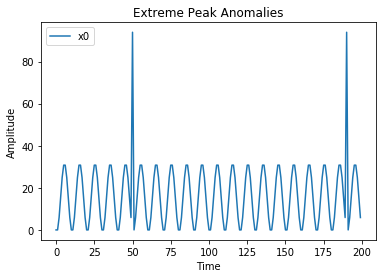

In [5]:
np.random.seed(1337)

STREAM_LENGTH = 200 #Number Of Sample Points
N = 1 #Number of Timeseries to be generated
K = 0 #Number of Timeseries that should correlate

dg = MultivariateDataGenerator(STREAM_LENGTH, N, K,behavior=simple_sin_generator)
df = dg.generate_baseline(initial_value_min=0, initial_value_max=0,noise=False)

df = dg.add_outliers({'extreme': [{'n': 0, 'timestamps': [(50,), (190,)]}]})

for col in df.columns:
    plt.plot(df[col], label=col)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Extreme Peak Anomalies');
plt.show()

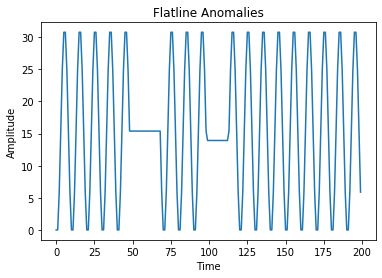

In [6]:
np.random.seed(1337)

STREAM_LENGTH = 200 #Number Of Sample Points
N = 1 #Number of Timeseries to be generated
K = 0 #Number of Timeseries that should correlate

dg = MultivariateDataGenerator(STREAM_LENGTH, N, K,behavior=simple_sin_generator)
df = dg.generate_baseline(initial_value_min=0, initial_value_max=0,noise=False)

df = dg.add_outliers({'flatline':[{'n': 0, 'timestamps': [(49, 68), (99, 113)]}]})

for col in df.columns:
    plt.plot(df[col], label=col)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Flatline Anomalies');
plt.show()

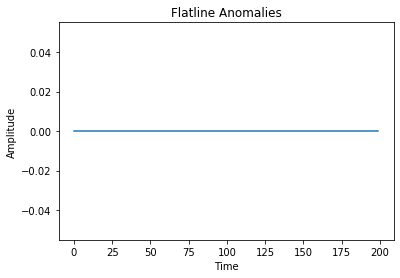

In [7]:
np.random.seed(1337)

STREAM_LENGTH = 200 #Number Of Sample Points
N = 1 #Number of Timeseries to be generated
K = 0 #Number of Timeseries that should correlate

dg = MultivariateDataGenerator(STREAM_LENGTH, N, K)
df = dg.generate_baseline(initial_value_min=0, initial_value_max=0,noise=False)

df = dg.add_outliers({'flatline':[{'n': 0, 'timestamps': [(49, 68), (99, 113)]}]})

for col in df.columns:
    plt.plot(df[col], label=col)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Flatline Anomalies');
plt.show()

In [8]:
df_test_fn = pd.read_csv('df_TEST_ENTITY_FOR_FLATLINEANOMALYGENERATOR.csv')

In [9]:
df_test_fn.head(10)

,id,evt_timestamp,speed,deviceid,_timestamp,adjusted_speed
0,73000,2020-01-22 16:11:12.531005,0.790322,73000,2020-01-22 16:11:12.531005,1.580645
1,73001,2020-01-22 16:12:12.531005,0.654237,73001,2020-01-22 16:12:12.531005,1.308474
2,73001,2020-01-22 16:13:12.531005,-1.082771,73001,2020-01-22 16:13:12.531005,-2.165543
3,73002,2020-01-22 16:14:12.531005,-0.206242,73002,2020-01-22 16:14:12.531005,-0.412485
4,73004,2020-01-22 16:15:12.531005,-0.324331,73004,2020-01-22 16:15:12.531005,-0.648661
5,73001,2020-01-22 16:16:12.531005,-0.894523,73001,2020-01-22 16:16:12.531005,-1.789046
6,73004,2020-01-22 16:17:12.531005,0.473646,73004,2020-01-22 16:17:12.531005,0.947292
7,73002,2020-01-22 16:18:12.531005,-0.738416,73002,2020-01-22 16:18:12.531005,-1.476831
8,73003,2020-01-22 16:19:12.531005,0.522686,73003,2020-01-22 16:19:12.531005,1.045371
9,73004,2020-01-22 16:20:12.531005,-0.248713,73004,2020-01-22 16:20:12.531005,-0.497426


In [10]:
df_test_fn.shape

(1446, 6)

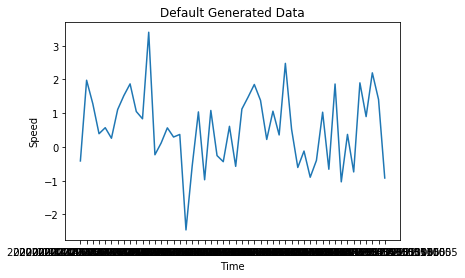

In [11]:
df_sample = df_test_fn.sample(50)
plt.plot(df_sample.evt_timestamp,df_sample.speed)
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Default Generated Data');
plt.show()

In [101]:
class AnomalyGeneratorExtremeValue(BaseTransformer):
    '''
    This function generates extreme anomaly.
    '''

    def __init__(self, input_item, factor, size, output_item):
        self.input_item = input_item
        self.output_item = output_item
        self.factor = int(factor)
        self.size = int(size)
        super().__init__()

    def execute(self, df):

        logger.debug('Dataframe shape {}'.format(df.shape))

        entity_type = self.get_entity_type()
        derived_metric_table_name = 'DM_' + entity_type.logical_name
        schema = entity_type._db_schema

        # store and initialize the counts by entity id
        db = self._entity_type.db

        raw_dataframe = None
        try:
            query, table = db.query(derived_metric_table_name, schema, column_names='KEY', filters={'KEY': self.output_item})
            raw_dataframe = db.get_query_data(query)
            key = '_'.join([derived_metric_table_name, self.output_item])
            logger.debug('Check for key {} in derived metric table {}'.format(self.output_item, raw_dataframe.shape))
        except Exception as e:
            logger.error('Checking for derived metric table %s failed with %s.' % (str(self.output_item), str(e)))
            key = str(derived_metric_table_name) + str(self.output_item)
            pass

        if raw_dataframe is not None and raw_dataframe.empty:
            # delete old counts if present
            db.model_store.delete_model(key)
            logger.debug('Reintialize count')

        counts_by_entity_id = None
        try:
            counts_by_entity_id = db.model_store.retrieve_model(key)
        except Exception as e2:
            logger.error('Counts by entity id not yet initialized - error: ' + str(e2))
            pass

        if counts_by_entity_id is None:
            counts_by_entity_id = {}
        logger.debug('Initial Grp Counts {}'.format(counts_by_entity_id))

        timeseries = df.reset_index()
        timeseries[self.output_item] = timeseries[self.input_item]
        df_grpby = timeseries.groupby('id')
        for grp in df_grpby.__iter__():

            entity_grp_id = grp[0]
            df_entity_grp = grp[1]

            #Initialize group counts
            count = 0
            if entity_grp_id in counts_by_entity_id:
                count = counts_by_entity_id[entity_grp_id]

            #Start index based on counts and factor
            if count == 0 or count%self.factor == 0:
                strt_idx = 0
            else:
                strt_idx = self.factor - count%self.factor

            #Update group counts for storage
            count += actual.size
            counts_by_entity_id[entity_grp_id] = count

            #Prepare numpy array for marking anomalies
            actual = df_entity_grp[output_col].values
            a = actual[strt_idx:]
            # Create NaN padding for reshaping
            nan_arr = np.repeat(np.nan, self.factor - a.size % self.factor)
            # Prepare numpy array to reshape
            a_reshape_arr = np.append(a,nan_arr)
            # Final numpy array to be transformed
            a1 = np.reshape(a_reshape_arr, (-1, self.factor)).T
            # Calculate 'local' standard deviation if it exceeds 1 to generate anomalies
            std = np.std(a1, axis=0)
            stdvec = np.maximum(np.where(np.isnan(std),1,std), np.ones(a1[0].size))
            # Mark Extreme anomalies
            a1[0] = np.multiply(a1[0],
                        np.multiply(np.random.choice([-1,1], a1.shape[1]),
                                    stdvec * self.size))
            # Flattening back to 1D array
            a2 = a1.T.flatten()
            # Removing NaN padding
            a2 = a2[~np.isnan(a2)]
            # Adding the missing elements to create final array
            final = np.append(actual[:strt_idx],a2)
            # Set values in the original dataframe
            timeseries.loc[df_entity_grp.index, self.output_item] = final

        logger.debug('Final Grp Counts {}'.format(counts_by_entity_id))

        # save the group counts to db
        try:
            db.model_store.store_model(key, counts_by_entity_id)
        except Exception as e3:
            logger.error('Counts by entity id cannot be stored - error: ' + str(e3))
            pass

        timeseries.set_index(df.index.names, inplace=True)
        return timeseries

    @classmethod
    def build_ui(cls):
        inputs = []
        inputs.append(UISingleItem(
                name='input_item',
                datatype=float,
                description='Item to base anomaly on'
                                              ))

        inputs.append(UISingle(
                name='factor',
                datatype=int,
                description='Frequency of anomaly e.g. A value of 3 will create anomaly every 3 datapoints',
                default=5
                                              ))

        inputs.append(UISingle(
                name='size',
                datatype=int,
                description='Size of extreme anomalies to be created. e.g. 10 will create 10x size extreme \
                             anomaly compared to the normal variance', default=10
                                              ))

        outputs = []
        outputs.append(UIFunctionOutSingle(
                name='output_item',
                datatype=float,
                description='Generated Item With Extreme anomalies'
                ))
        return (inputs, outputs)


NameError: name 'BaseTransformer' is not defined

In [12]:
self_factor = 5 #Create anomaly at every nth point
self_size = 100
self_output_item = 'extreme_speed'
self_input_item = 'speed'

df_test_fn = pd.read_csv('df_TEST_ENTITY_FOR_FLATLINEANOMALYGENERATOR.csv')
counts_by_entity_id = {}
final_dataframe = pd.DataFrame(data=None, columns=['id',output_col,input_col])
#final_dataframe.index.name = 'idx'
#Mimics the actual dataframes coming in the execute method of Extreme Anomaly Generator
for time_splits in np.array_split(df_test_fn.iloc[:52],4):
    timeseries = time_splits.copy()
    timeseries.index.name = 'idx'
    
    
    #***********Execute method starts for Anomaly Generator**************
    #Group by entity_ids
    timeseries.reset_index(inplace=True)
    timeseries[self_output_item] = timeseries[self_input_item]
    df_grpby = timeseries.groupby('id')
    for grp in df_grpby.__iter__():

        entity_grp_id = grp[0]
        df_entity_grp = grp[1]
                        
        #Initialize group counts
        count = 0
        if entity_grp_id in counts_by_entity_id:
            count = counts_by_entity_id[entity_grp_id]

        #Start index based on counts and factor
        if count == 0 or count%self_factor == 0:
            strt_idx = 0
        else:
            strt_idx = self_factor - count%self_factor

        #Update group counts for storage
        actual = df_entity_grp[self_output_item].values
        count += actual.size
        counts_by_entity_id[entity_grp_id] = count

        #Prepare numpy array for marking anomalies
        a = actual[strt_idx:]
        # Create NaN padding for reshaping
        nan_arr = np.repeat(np.nan, self_factor - a.size % self_factor)
        # Prepare numpy array to reshape
        a_reshape_arr = np.append(a,nan_arr)
        # Final numpy array to be transformed
        a1 = np.reshape(a_reshape_arr, (-1, self_factor)).T
        # Calculate 'local' standard deviation if it exceeds 1 to generate anomalies
        std = np.std(a1, axis=0)
        stdvec = np.maximum(np.where(np.isnan(std),1,std), np.ones(a1[0].size))
        # Mark Extreme anomalies
        a1[0] = np.multiply(a1[0],
                    np.multiply(np.random.choice([-1,1], a1.shape[1]),
                                stdvec * self_size))
        # Flattening back to 1D array
        a2 = a1.T.flatten()
        # Removing NaN padding
        a2 = a2[~np.isnan(a2)]
        # Adding the missing elements to create final array
        final = np.append(actual[:strt_idx],a2)
        # Set values in the original dataframe
        timeseries.loc[df_entity_grp.index, self_output_item] = final

        counts_by_entity_id[entity_grp_id] = count
    print(timeseries[['id',self_input_item,self_output_item]].sort_values(['id']))
    #Save the group counts to cos
    #***********Execute method ends for Anomaly Generator**************
#print('Final Dataframe')
#print(final_dataframe[['id',input_col,output_col]])

NameError: name 'output_col' is not defined

73000
       id  flatline_speed     speed
0   73000        0.790322  0.790322
11  73000        0.016065  0.016065
16  73000        0.480793  0.480793
19  73000        0.374527  0.210927
8   73000        0.374527  0.923533
10  73000        0.374527  0.371534
13  73000        0.374527  1.509245
21  73000        1.512673  1.512673
2   73000        0.315779  0.315779
5   73000        1.477163  1.477163
22  73000        1.079246 -0.419203


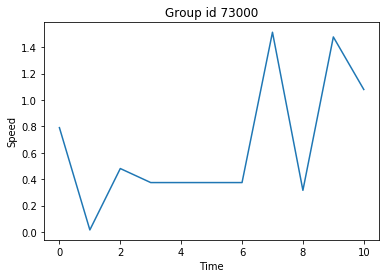

73001
       id  flatline_speed     speed
1   73001        0.654237  0.654237
2   73001       -1.082771 -1.082771
5   73001       -0.894523 -0.894523
15  73001        0.180586  0.934206
24  73001        0.180586  1.291779
2   73001        0.180586 -0.631406
4   73001        0.180586 -0.883098
6   73001        0.575673  0.575673
9   73001        0.486764  0.486764
18  73001       -0.263566 -0.263566
20  73001       -0.051227  1.320896
22  73001       -0.051227 -0.963850
1   73001       -0.051227 -0.418442
3   73001       -0.051227  0.751602
12  73001        1.329896  1.329896
13  73001       -0.088745 -0.088745
16  73001        0.917227  0.917227


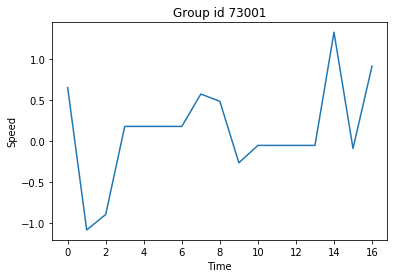

73002
       id  flatline_speed     speed
3   73002       -0.206242 -0.206242
7   73002       -0.738416 -0.738416
10  73002        0.044330  0.044330
20  73002       -0.004702 -0.362968
22  73002       -0.004702  0.001067
23  73002       -0.004702  1.234016
0   73002       -0.004702  0.179581
5   73002        0.780222  0.780222
14  73002       -1.127193 -1.127193
17  73002        0.950216  0.950216
19  73002        0.088540 -0.340128
4   73002        0.088540  0.826810
6   73002        0.088540  1.343017
9   73002        0.088540 -0.218242
11  73002        0.721911  0.721911
14  73002        1.859699  1.859699
21  73002        1.378829  1.378829
24  73002        0.791654 -0.370443


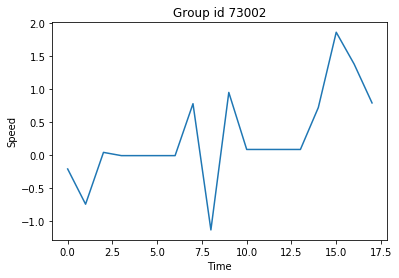

73003
       id  flatline_speed     speed
8   73003        0.522686  0.522686
13  73003        1.029135  1.029135
1   73003        0.101809  0.101809
15  73003        0.775910 -1.059000
16  73003        0.775910  0.370400
0   73003        0.775910 -0.268806
18  73003        0.775910  0.491090
20  73003        0.660503  0.660503
23  73003        0.979548  0.979548


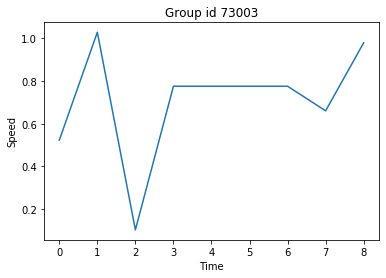

73004
       id  flatline_speed     speed
4   73004       -0.324331 -0.324331
6   73004        0.473646  0.473646
9   73004       -0.248713 -0.248713
12  73004        0.642455  0.145470
14  73004        0.642455  0.293628
17  73004        0.642455  0.701073
18  73004        0.642455  1.704397
21  73004        2.394469  2.394469
3   73004       -0.045843 -0.045843
7   73004       -0.321714 -0.321714
11  73004        0.642455 -1.141533
12  73004        0.642455  0.319655
23  73004        0.642455 -1.143788
24  73004        0.642455  0.036532
7   73004        1.123355  1.123355
8   73004       -0.273063 -0.273063
10  73004        0.564421  0.564421
15  73004        0.602650  0.833748
17  73004        0.602650  0.252470
19  73004        0.602650  1.114968


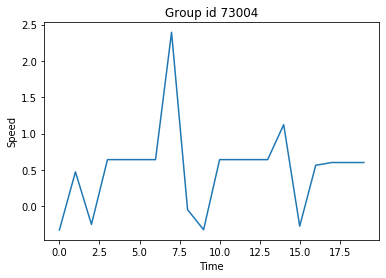

In [70]:
df_test_fn = pd.read_csv('df_TEST_ENTITY_FOR_FLATLINEANOMALYGENERATOR.csv')
factor = 4 #Create anomaly at every 3rd point
self_width = 4 #Anomaly width
output_col = 'flatline_speed'
input_col = 'speed'
counts_by_entity_id = {}
final_dataframe = pd.DataFrame(data=None, columns=['id',output_col,input_col])
#Mimics the actual dataframes coming in the execute method of Extreme Anomaly Generator
for time_splits in np.array_split(df_test_fn.iloc[:75],3):
    timeseries = time_splits.copy()
    timeseries[output_col] = timeseries[input_col]
    timeseries.reset_index(inplace=True)
    
    #***********Execute method starts for Anomaly Generator**************
    df_grpby=timeseries.groupby('id')
    for grp in df_grpby.__iter__():

        entity_grp_id = grp[0]
        df_entity_grp = grp[1]
        #print('Group {} Indexes {}'.format(grp[0],df_entity_grp.index))

        count = 0
        width = self_width
        local_mean = df_entity_grp.iloc[:10][input_col].mean()
        if entity_grp_id in counts_by_entity_id:
            count = counts_by_entity_id[entity_grp_id][0]
            width = counts_by_entity_id[entity_grp_id][1]
            if count != 0:
                local_mean = counts_by_entity_id[entity_grp_id][2]

        mark_anomaly = False
        for grp_row_index in df_entity_grp.index:
            count += 1
            
            if width!=self_width or count%factor == 0:
                #Start marking points
                mark_anomaly = True

            if mark_anomaly:
                timeseries[output_col].iloc[grp_row_index] = local_mean
                width -= 1
                #print(local_mean)
                #print('Anomaly Index Value{}'.format(grp_row_index))

            if width==0:
                #End marking points
                mark_anomaly =False
                #Update values
                width = self_width
                count = 0
                local_mean = df_entity_grp.iloc[:10][input_col].mean()

        counts_by_entity_id[entity_grp_id] = (count,width,local_mean)
    #print(counts_by_entity_id)
    #print(timeseries[['id',output_col,input_col]])
    final_dataframe = final_dataframe.append(timeseries[['id',output_col,input_col]])
    #print(final_dataframe.append(timeseries[['id',output_col,input_col]]))
#print(final_dataframe.head())
df_grpby=final_dataframe.groupby('id')
for grp in df_grpby.__iter__():
    entity_grp_id = grp[0]
    df_entity_grp = grp[1]
    print(entity_grp_id)
    print(df_entity_grp)
    df_entity_grp.reset_index(inplace=True)
    plt.plot(df_entity_grp.index,df_entity_grp[output_col])
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.title('Group id {}'.format(entity_grp_id));
    plt.show()
    #Save the group counts to cos
    #***********Execute method ends for Anomaly Generator**************


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


73000
       id  flatline_speed     speed
0   73000        0.790322  0.790322
11  73000        0.016065  0.016065
16  73000        0.480793  0.480793
19  73000             NaN  0.210927
8   73000             NaN  0.923533
10  73000             NaN  0.371534
13  73000             NaN  1.509245
21  73000        1.512673  1.512673
2   73000        0.315779  0.315779
5   73000        1.477163  1.477163
22  73000             NaN -0.419203


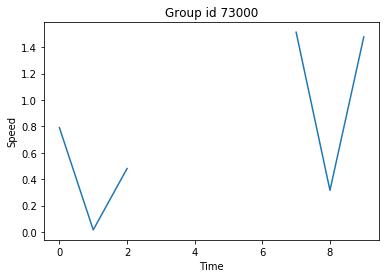

73001
       id  flatline_speed     speed
1   73001        0.654237  0.654237
2   73001       -1.082771 -1.082771
5   73001       -0.894523 -0.894523
15  73001             NaN  0.934206
24  73001             NaN  1.291779
2   73001             NaN -0.631406
4   73001             NaN -0.883098
6   73001        0.575673  0.575673
9   73001        0.486764  0.486764
18  73001       -0.263566 -0.263566
20  73001             NaN  1.320896
22  73001             NaN -0.963850
1   73001             NaN -0.418442
3   73001             NaN  0.751602
12  73001        1.329896  1.329896
13  73001       -0.088745 -0.088745
16  73001        0.917227  0.917227


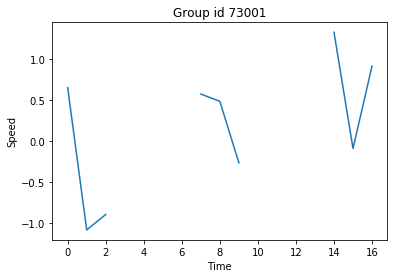

73002
       id  flatline_speed     speed
3   73002       -0.206242 -0.206242
7   73002       -0.738416 -0.738416
10  73002        0.044330  0.044330
20  73002             NaN -0.362968
22  73002             NaN  0.001067
23  73002             NaN  1.234016
0   73002             NaN  0.179581
5   73002        0.780222  0.780222
14  73002       -1.127193 -1.127193
17  73002        0.950216  0.950216
19  73002             NaN -0.340128
4   73002             NaN  0.826810
6   73002             NaN  1.343017
9   73002             NaN -0.218242
11  73002        0.721911  0.721911
14  73002        1.859699  1.859699
21  73002        1.378829  1.378829
24  73002             NaN -0.370443


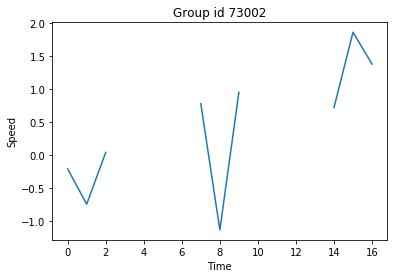

73003
       id  flatline_speed     speed
8   73003        0.522686  0.522686
13  73003        1.029135  1.029135
1   73003        0.101809  0.101809
15  73003             NaN -1.059000
16  73003             NaN  0.370400
0   73003             NaN -0.268806
18  73003             NaN  0.491090
20  73003        0.660503  0.660503
23  73003        0.979548  0.979548


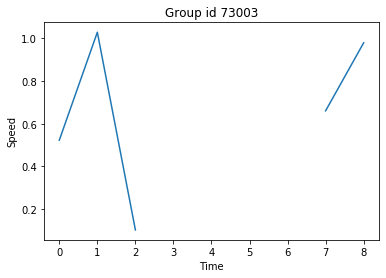

73004
       id  flatline_speed     speed
4   73004       -0.324331 -0.324331
6   73004        0.473646  0.473646
9   73004       -0.248713 -0.248713
12  73004             NaN  0.145470
14  73004             NaN  0.293628
17  73004             NaN  0.701073
18  73004             NaN  1.704397
21  73004        2.394469  2.394469
3   73004       -0.045843 -0.045843
7   73004       -0.321714 -0.321714
11  73004             NaN -1.141533
12  73004             NaN  0.319655
23  73004             NaN -1.143788
24  73004             NaN  0.036532
7   73004        1.123355  1.123355
8   73004       -0.273063 -0.273063
10  73004        0.564421  0.564421
15  73004             NaN  0.833748
17  73004             NaN  0.252470
19  73004             NaN  1.114968


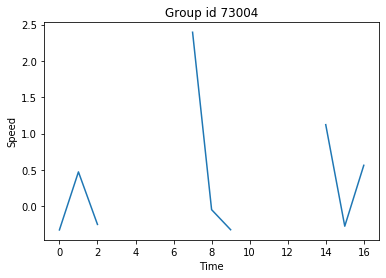

In [71]:
df_test_fn = pd.read_csv('df_TEST_ENTITY_FOR_FLATLINEANOMALYGENERATOR.csv')
factor = 4 #Create anomaly at every 3rd point
self_width = 4 #Anomaly width
output_col = 'flatline_speed'
input_col = 'speed'
counts_by_entity_id = {}
final_dataframe = pd.DataFrame(data=None, columns=['id',output_col,input_col])
#Mimics the actual dataframes coming in the execute method of Extreme Anomaly Generator
for time_splits in np.array_split(df_test_fn.iloc[:75],3):
    timeseries = time_splits.copy()
    timeseries[output_col] = timeseries[input_col]
    timeseries.reset_index(inplace=True)
    
    #***********Execute method starts for Anomaly Generator**************
    df_grpby=timeseries.groupby('id')
    for grp in df_grpby.__iter__():

        entity_grp_id = grp[0]
        df_entity_grp = grp[1]
        #print('Group {} Indexes {}'.format(grp[0],df_entity_grp.index))

        count = 0
        width = self_width
        if entity_grp_id in counts_by_entity_id:
            count = counts_by_entity_id[entity_grp_id][0]
            width = counts_by_entity_id[entity_grp_id][1]

        mark_anomaly = False
        for grp_row_index in df_entity_grp.index:
            count += 1
            
            if width!=self_width or count%factor == 0:
                #Start marking points
                mark_anomaly = True

            if mark_anomaly:
                timeseries[output_col].iloc[grp_row_index] = np.NaN
                width -= 1
                #print(local_mean)
                #print('Anomaly Index Value{}'.format(grp_row_index))

            if width==0:
                #End marking points
                mark_anomaly =False
                #Update values
                width = self_width
                count = 0

        counts_by_entity_id[entity_grp_id] = (count,width)
    #print(counts_by_entity_id)
    #print(timeseries[['id',output_col,input_col]])
    final_dataframe = final_dataframe.append(timeseries[['id',output_col,input_col]])
    #print(final_dataframe.append(timeseries[['id',output_col,input_col]]))
#print(final_dataframe.head())
df_grpby=final_dataframe.groupby('id')
for grp in df_grpby.__iter__():
    entity_grp_id = grp[0]
    df_entity_grp = grp[1]
    print(entity_grp_id)
    print(df_entity_grp)
    df_entity_grp.reset_index(inplace=True)
    plt.plot(df_entity_grp.index,df_entity_grp[output_col])
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.title('Group id {}'.format(entity_grp_id));
    plt.show()
    #Save the group counts to cos
    #***********Execute method ends for Anomaly Generator**************


In [44]:
df = pd.DataFrame(columns=list('AB'))
df2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('AB'))
df.append(df2)

,A,B
0,5,6
1,7,8


In [55]:
class FlatlineOutlierGenerator():
    def __init__(self, timestamps=None, factor=8):
        timestamps = timestamps or []
        self.timestamps = timestamps
        self.factor = factor

    def add_outliers(self, timeseries,input_col):
        print(timeseries.shape)
        
        additional_values = np.zeros(timeseries[input_col].size)
        print(additional_values.shape)
        for start, end in self.timestamps:
            local_mean = timeseries.iloc[max(0, start - 10):end + 10][input_col].mean()
            print(local_mean)
            print(list(range(start, end)))
            print(timeseries.iloc[start:end][input_col], "  ", -timeseries.iloc[start:end][input_col] + local_mean)
            
            additional_values[list(range(start, end))] += -timeseries.iloc[start:end][input_col] + local_mean
            print(additional_values.shape)
            timeseries[input_col] += additional_values
        return timeseries
    
flatline_gen = FlatlineOutlierGenerator(timestamps=[(49, 68), (99, 113)])

In [15]:
df_copy = df_test_fn.head(200)
df_copy.drop(['adjusted_speed'], axis=1,inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [26]:
df_copy.sample(5)

,id,evt_timestamp,speed,deviceid,_timestamp
71,73002,2020-01-22 17:22:12.531005,1.378829,73002,2020-01-22 17:22:12.531005
41,73003,2020-01-22 16:52:12.531005,0.370400,73003,2020-01-22 16:52:12.531005
93,73000,2020-01-22 17:44:12.531005,1.252408,73000,2020-01-22 17:44:12.531005
30,73002,2020-01-22 16:41:12.531005,0.780222,73002,2020-01-22 16:41:12.531005
149,73002,2020-01-22 18:40:12.531005,-1.033504,73002,2020-01-22 18:40:12.531005


In [27]:
df_copy.shape

(200, 5)

In [32]:
import logging
import numpy as np
import pandas as pd

from iotfunctions.base import BaseTransformer
from iotfunctions.ui import (UISingle, UIFunctionOutSingle, UISingleItem)
logger = logging.getLogger(__name__)

PACKAGE_URL = 'git+https://github.com/ankit-jha/addCustomIotFn@flatline_anomaly_package'

class FlatlineAnomalyGenerator(BaseTransformer):
    '''
    This function generates flatline anomaly.
    '''

    def __init__(self, input_item, width, factor, output_item):
        self.input_item = input_item
        self.output_item = output_item
        self.width = int(width)
        self.factor = int(factor)
        super().__init__()

    def execute(self, df):
        timeseries = df.reset_index()
        #Create a zero value series
        additional_values = pd.Series(np.zeros(timeseries[self.input_item].size),index=timeseries.index)
        timestamps_indexes = []
        #Divide the timeseries in (factor)number of splits.Each split will have one anomaly
        for time_splits in np.array_split(timeseries,self.factor):
            start = time_splits.sample().index[0]
            end = min(start+self.width,time_splits.index[-1])
            timestamps_indexes.append((start,end))
        #Create flatline anomalies in every split
        for start, end in timestamps_indexes:
            local_mean = timeseries.iloc[max(0, start - 10):end + 10][self.input_item].mean()
            additional_values.iloc[start:end] += local_mean - timeseries[self.input_item].iloc[start:end]
            timeseries[self.output_item] = additional_values + timeseries[self.input_item]

        #timeseries.set_index(df.index.names,inplace=True)
        return timeseries

    @classmethod
    def build_ui(cls):
        inputs = []
        inputs.append(UISingleItem(
                name='input_item',
                datatype=float,
                description='Item to base anomaly on'
                                              ))

        inputs.append(UISingle(
                name='width',
                datatype=int,
                description='Width of the anomaly created- default 100'
                                              ))

        inputs.append(UISingle(
                name='factor',
                datatype=int,
                description='No. of flatline anomalies to be created'
                                              ))

        outputs = []
        outputs.append(UIFunctionOutSingle(
                name='output_item',
                datatype=float,
                description='Generated Item With Flatline anomalies'
                ))
        return (inputs, outputs)

(200, 7)


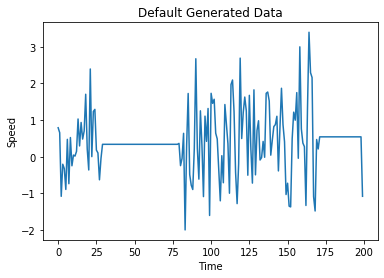

In [33]:
flatline_gen = FlatlineAnomalyGenerator('speed','50','2','output_col')
df_flatline = flatline_gen.execute(df_copy)
print(df_flatline.shape)
plt.plot(df_flatline.index,df_flatline.output_col)
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Default Generated Data');
plt.show()

In [162]:
!python -c 'import pandas as pd; print(pd.__version__)'

0.25.3


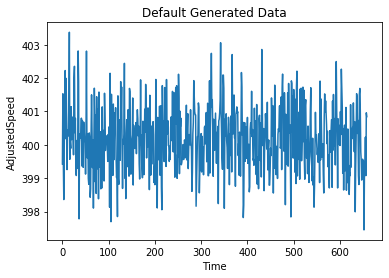

In [57]:
df_test = pd.read_csv('/Users/ankitjha/Repositories/github/functions/_DM_Anomaly_Test_Boiler_Type__202002171424.csv')
df_custom_fn = df_test.reset_index()
plt.plot(df_custom_fn.index,df_custom_fn['VALUE_N'])
plt.xlabel('Time')
plt.ylabel('AdjustedSpeed')
plt.title('Default Generated Data');
plt.show()

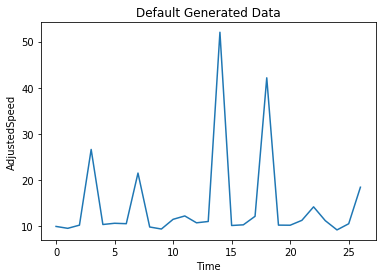

In [200]:
df_test = pd.read_csv('/Users/ankitjha/Repositories/github/functions/_DM_Anomaly_Test_Boiler_Type__202002252116.csv')
df_custom_fn = df_test.reset_index()
plt.plot(df_custom_fn.index,df_custom_fn['VALUE_N'])
plt.xlabel('Time')
plt.ylabel('AdjustedSpeed')
plt.title('Default Generated Data');
plt.show()

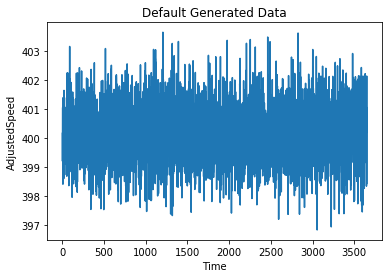

In [59]:
df_test = pd.read_csv('/Users/ankitjha/Repositories/github/functions/_DM_Anomaly_Test_Boiler_Type__202002171558.csv')
df_custom_fn = df_test.reset_index()
plt.plot(df_custom_fn.index,df_custom_fn['VALUE_N'])
plt.xlabel('Time')
plt.ylabel('AdjustedSpeed')
plt.title('Default Generated Data');
plt.show()

In [12]:
import logging
import numpy as np
import pandas as pd

from iotfunctions.base import BaseTransformer
from iotfunctions.ui import (UISingle, UIFunctionOutSingle, UISingleItem)
logger = logging.getLogger(__name__)

PACKAGE_URL = 'git+https://github.com/ankit-jha/addCustomIotFn@extreme_anomaly_package'

class ExtremeAnomalyGenerator(BaseTransformer):
    '''
    This function generates extreme anomaly.
    '''

    def __init__(self, input_item, factor, size, output_item):
        self.input_item = input_item
        self.output_item = output_item
        self.factor = int(factor)
        self.size = int(size)
        super().__init__()

    def execute(self, df):
        timeseries = df.copy().reset_index()
        #Create a zero value series
        #additional_values = timeseries[self.input_item].copy()
        #additional_values.loc[:,:] = 0
        additional_values = pd.Series(np.zeros(timeseries[self.input_item].size),index=timeseries.index)
        timestamps_indexes = []
        #Divide the timeseries in (factor)number of splits.Each split will have one anomaly
        for time_splits in np.array_split(timeseries,self.factor):
            start = time_splits.sample().index[0]
            timestamps_indexes.append(start)
        #Create extreme anomalies in every split
        for start  in timestamps_indexes:
            local_std = timeseries[self.input_item].iloc[max(0, start - 10):start + 10].std()
            additional_values.iloc[start] += np.random.choice([-1, 1]) * self.size * local_std
            timeseries[self.output_item] = additional_values + timeseries[self.input_item]

        #timeseries.set_index(df.index.names,inplace=True)
        return timeseries

    @classmethod
    def build_ui(cls):
        inputs = []
        inputs.append(UISingleItem(
                name='input_item',
                datatype=float,
                description='Item to base anomaly on'
                                              ))

        inputs.append(UISingle(
                name='factor',
                datatype=int,
                description='No. of extreme anomalies to be created'
                                              ))

        inputs.append(UISingle(
                name='size',
                datatype=int,
                description='Size of extreme anomalies to be created. e.g. 10 will create 10x size extreme anomaly compared to the normal variance'
                                              ))

        outputs = []
        outputs.append(UIFunctionOutSingle(
                name='output_item',
                datatype=float,
                description='Generated Item With Extreme anomalies'
                ))
        return (inputs, outputs)


(200, 7)


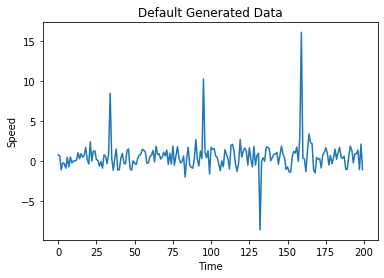

In [13]:
extreme_gen = ExtremeAnomalyGenerator('speed','4','10','output_col')
df_flatline = extreme_gen.execute(df_copy)
print(df_flatline.shape)
plt.plot(df_flatline.index,df_flatline.output_col)
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Default Generated Data');
plt.show()

In [1]:
!python -c "import pandas as pd;print(pd.__version__)"

0.24.0


In [2]:
!python -c "import numpy as pd;print(pd.__version__)"

1.17.3


In [7]:
import logging
import numpy as np
import pandas as pd

from iotfunctions.base import BaseTransformer
from iotfunctions.ui import (UISingle, UIFunctionOutSingle, UISingleItem)
logger = logging.getLogger(__name__)

PACKAGE_URL = 'git+https://github.com/ankit-jha/addCustomIotFn@nodata_anomaly_package'

class NoDataAnomalyGenerator(BaseTransformer):
    '''
    This function generates nodata anomaly.
    '''

    def __init__(self, input_item, width, factor, output_item):
        self.input_item = input_item
        self.output_item = output_item
        self.width = int(width)
        self.factor = int(factor)
        super().__init__()

    def execute(self, df):
        timeseries = df.copy().reset_index()
        #Create a zero value series
        additional_values = pd.Series(np.zeros(timeseries[self.input_item].size),index=timeseries.index)
        timestamps_indexes = []
        #Divide the timeseries in (factor)number of splits.Each split will have one anomaly
        for time_splits in np.array_split(timeseries,self.factor):
            start = time_splits.sample().index[0]
            end = min(start+self.width,time_splits.index[-1])
            timestamps_indexes.append((start,end))
        #Create flatline anomalies in every split
        for start, end in timestamps_indexes:
            additional_values.iloc[start:end] += np.NaN
            timeseries[self.output_item] = additional_values + timeseries[self.input_item]

        #timeseries.set_index(df.index.names,inplace=True)
        return timeseries

    @classmethod
    def build_ui(cls):
        inputs = []
        inputs.append(UISingleItem(
                name='input_item',
                datatype=float,
                description='Item to base anomaly on'
                                              ))

        inputs.append(UISingle(
                name='width',
                datatype=int,
                description='Width of the anomaly created- default 100'
                                              ))

        inputs.append(UISingle(
                name='factor',
                datatype=int,
                description='No. of nodata anomalies to be created'
                                              ))

        outputs = []
        outputs.append(UIFunctionOutSingle(
                name='output_item',
                datatype=float,
                description='Generated Item With NoData anomalies'
                ))
        return (inputs, outputs)


In [8]:
df_copy = df_test_fn.head(200)
df_copy.drop(['adjusted_speed'], axis=1,inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [204]:
df_copy

NameError: name 'df_copy' is not defined

(200, 7)


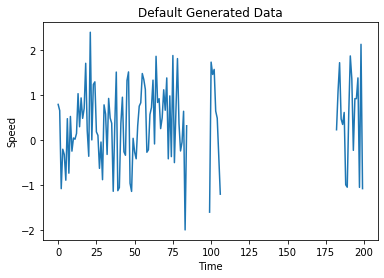

In [9]:
nodata_gen = NoDataAnomalyGenerator('speed','75','2','output_col')
df_flatline = nodata_gen.execute(df_copy)
print(df_flatline.shape)
plt.plot(df_flatline.index,df_flatline.output_col)
plt.xlabel('Time')
plt.ylabel('Speed')
plt.title('Default Generated Data');
plt.show()